
# Why should I know Machine Learning ?
## Map a unknown output with as few sample as possible via advanced regression tools

In [1]:
import numpy as np
from pyDOE import lhs
import sklearn.preprocessing as skp
import sklearn.svm as sksv
import sklearn.ensemble as ske

import pylab as pl
pl.style.use("publication")

from matplotlib.colors import LogNorm, SymLogNorm

class MidpointNormalize(pl.matplotlib.colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        pl.matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

%matplotlib inline

/usr/lib/python3.6/site-packages/sklearn/externals/joblib/_multiprocessing_helpers.py:28: UserWarning: [Errno 30] Read-only file system.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


We will try to map a complex (strongly non-linear) function with as few a samples as possible.

We will use the Styblinski–Tang function defined as

\begin{align}
    f([x_1...x_n]) = \sum_{i=1}^n \frac{x_i^4 - 16 x_i^22 + 5 x_i}{2}
\end{align}

And we will work with 2 variables.

In order to map that function, we will combine two tools : an efficient latin hypercube sampler and a support vector regression with a gaussian kernel trick.

In [2]:
def non_linear_function(*x):
    # definition of the Styblinski–Tang function.
    return sum([x_i**4 - 16 * x_i**2 + 5 * x_i / 2
                for x_i in x])

The original function, defined bewteen -4 and 4 looks like:

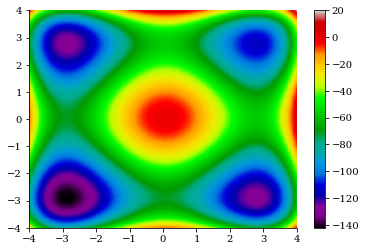

In [3]:
x = np.linspace(-4, 4, 100)
y = np.linspace(-4, 4, 100)
z = non_linear_function(*np.meshgrid(x, y))

pl.pcolormesh(x, y, z, cmap="nipy_spectral", shading="gouraud")
pl.colorbar()

Now, we try to reproduce this output with as few samples as possible.

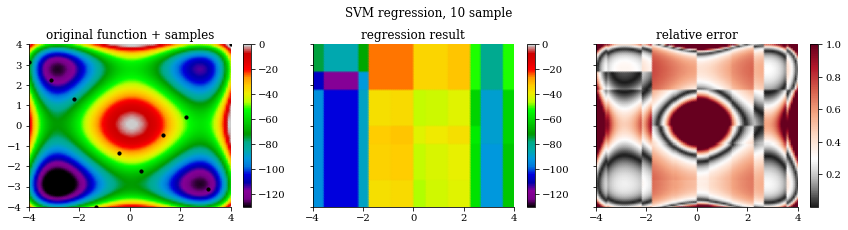

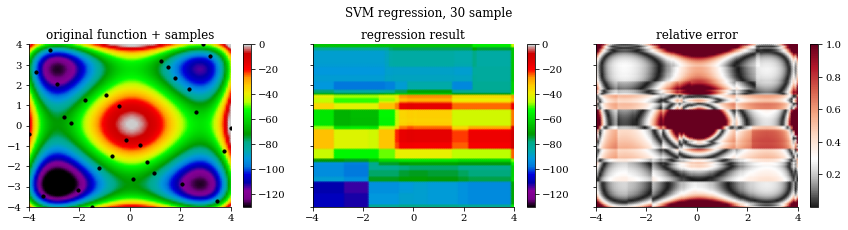

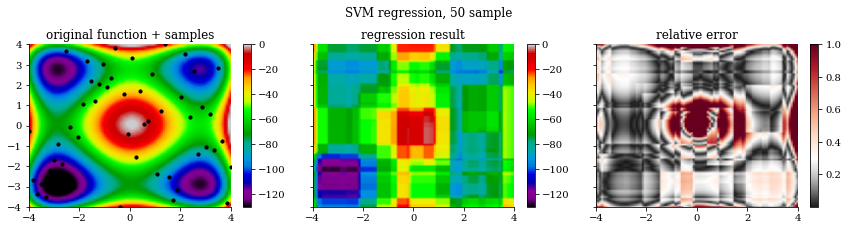

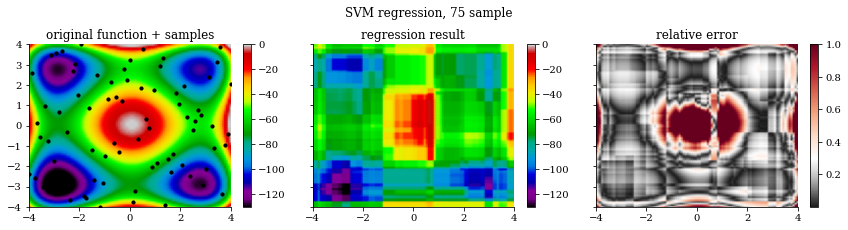

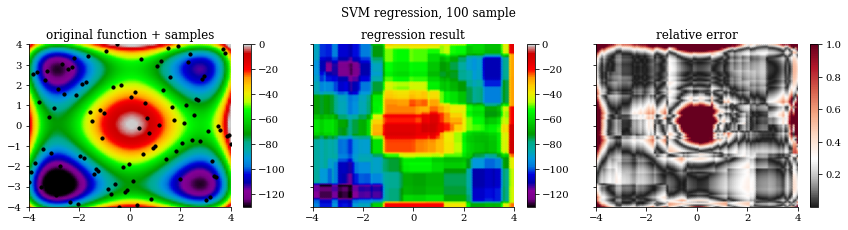

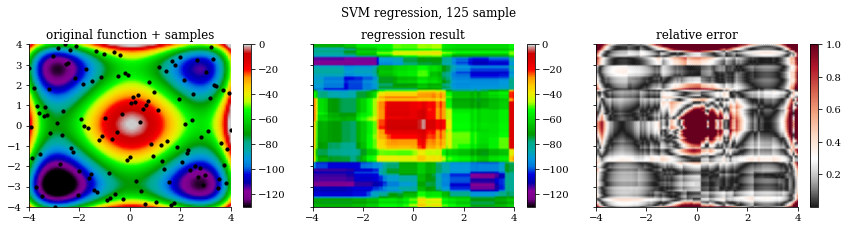

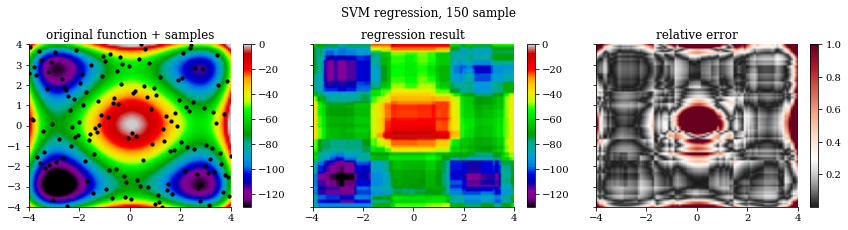

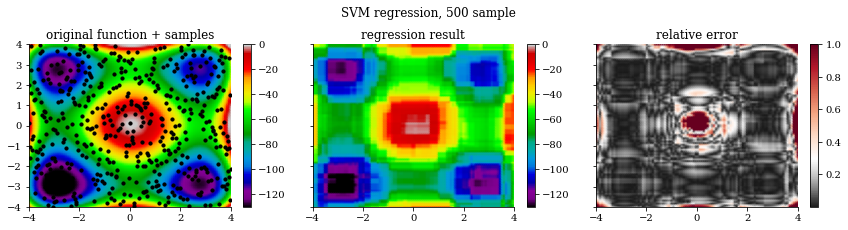

In [5]:
for n_sample in [10, 30, 50, 75, 100, 125, 150, 500]:
    x = np.linspace(-4, 4, 100)
    y = np.linspace(-4, 4, 100)
    z = non_linear_function(*np.meshgrid(x, y))

    # This is to rescale the inputs between our -4/4 range
    minmax_scale = skp.MinMaxScaler(feature_range=(-4, 4))
    # This is to rescale the output into a 0/1 range
    std_scale = skp.StandardScaler()
    # We generate n samples via the LHS method
    X = minmax_scale.fit_transform(lhs(2, samples=n_sample, criterion="center"))
    # We scale the result of our function.
    # The function computation is the slow part of all the work in a real world case.
    Y = std_scale.fit_transform(non_linear_function(*X.T)[:, None]).squeeze()

    fig, axs = pl.subplots(1, 3, sharex="all", sharey="all", figsize=(12, 3))
    pl.sca(axs[0])
    pl.pcolormesh(x, y, z, cmap="nipy_spectral",
                  vmin=-130, vmax=0, shading="gouraud")
    pl.colorbar()
    pl.scatter(*X.T, color="black", s=10)
    pl.title("original function + samples")
    pl.xlim(-4, 4)
    pl.ylim(-4, 4)

    # A Support Vector Regression is used to fit the simulation results
    #regressor = sksv.SVR()
    regressor = ske.RandomForestRegressor(5, n_jobs=32)
    regressor.fit(X, Y)
    
    # We create a full grid
    xx, yy = np.meshgrid(x, y)
    
    # We predict the output of our simulation via the trained regressor :
    # in a real case, this is way faster than calling the model itself.
    YY = regressor.predict(np.vstack([xx.flatten(),
                                      yy.flatten()]).T).reshape(xx.shape)

    pl.sca(axs[1])
    pl.pcolormesh(xx, yy, std_scale.inverse_transform(YY),
                  cmap="nipy_spectral",
                  vmin=-130, vmax=0, shading="gouraud")
    pl.colorbar()
    pl.title("regression result")
    
    # We compute the relative error to have an idea of how the prediction behave
    pl.sca(axs[2])
    relerr = (np.abs(std_scale.inverse_transform(YY) -
                     non_linear_function(xx, yy)) /
              np.abs(non_linear_function(xx, yy) + 1))
    pl.pcolormesh(xx, yy, relerr,
                  cmap="RdGy_r", norm=MidpointNormalize(1E-3, 1, .3),
                  shading="gouraud")
    pl.colorbar()
    pl.title("relative error")
    pl.suptitle("SVM regression, %i sample" % n_sample, y=1.05)
    pl.tight_layout()